# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Analysis](#Analysis)
- [Heatmaps of Best Pitches](#Heatmaps-of-Best-Pitches)
    - [4-Seam](#4-Seam)
    - [Cutter](#Cutter)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)

# Imports

In [1]:
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

xrv = pd.read_csv('../data/xrv-pitches.csv', index_col = [0])
rv_pitches = pd.read_csv('../data/pitches-rv-table.csv', index_col = [0])
grouped_pitches_rv = pd.read_csv('../data/grouped-pitches-rv-table.csv', index_col = [0])

pd.set_option('max_columns', None)
print(xrv.shape)
xrv.head()

(680883, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,6.3,1.61,4.07,-0.149,1,-0.063
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,6.7,0.37,2.75,-0.007,1,0.132
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,6.6,0.10,1.94,-0.004,1,0.117
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,6.7,-0.91,2.50,-0.149,1,-0.068
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,6.6,-0.31,2.02,-0.004,1,0.206


In [3]:
print(rv_pitches.shape)
rv_pitches.head()

(3346, 8)


,player_name,p_throws,pitch_type,n_pitches,RV,RV/100,xRV,xRV/100
0,"Abbott, Cory",R,FF,207.0,17.376,8.39,14.826,7.16
1,"Abreu, Albert",R,FF,103.0,2.765,2.68,3.719,3.61
2,"Abreu, Bryan",R,FF,310.0,14.225,4.59,11.294,3.64
3,"Acevedo, Domingo",R,FF,88.0,6.004,6.82,5.375,6.11
4,"Adam, Jason",R,FF,125.0,7.373,5.90,5.128,4.10


In [4]:
grouped_pitches_rv.head()

,player_name,p_throws,pitch_type,FF_count,SI_count,FC_count,RV,RV/100,xRV,xRV/100,CU_count,SL_count,KC_count,CH_count,FS_count
0,"Abbott, Cory",R,FF,207.0,0.0,0.0,17.376,8.39,15.706,7.59,NaN,NaN,NaN,NaN,NaN
1,"Abreu, Albert",R,FF,103.0,0.0,0.0,2.765,2.68,3.711,3.60,NaN,NaN,NaN,NaN,NaN
2,"Abreu, Albert",R,SI,0.0,212.0,0.0,10.675,5.04,9.979,4.71,NaN,NaN,NaN,NaN,NaN
3,"Abreu, Bryan",R,FF,310.0,0.0,0.0,14.225,4.59,12.221,3.94,NaN,NaN,NaN,NaN,NaN
4,"Abreu, Bryan",R,SI,0.0,2.0,0.0,-0.011,-0.55,0.000,0.00,NaN,NaN,NaN,NaN,NaN


# Preprocessing

### Multicolinearity - VIF

**Independent Variables:** Velocity, Spin Rate, VB, HB, Release Extension, Horizontal Release Position, Vertical Release Position, Horizontal Plate Coords, Vertical Plate Coords

**Dependent Variable:** rv

In [5]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 
                 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'release_extension',
                 'plate_x', 'plate_z', 'rv']]

features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(10)

,feature,VIF
9,rv,1.012208
7,plate_x,1.110543
4,release_pos_x,1.454762
2,pfx_x,1.466135
3,pfx_z,3.114446
8,plate_z,7.451706
1,spin_rate,50.839720
5,release_pos_z,103.361778
6,release_extension,152.722320
0,velo,277.759432


# Analysis

### Base-Out-State and Linear Weights for each Ball in Play Event

In [6]:
data.groupby(['events'], as_index = False)['re24', 'lin_weight_above_outs', 
                                           'lin_weights_above_outs_scale', 'rv'].mean()

,events,re24,lin_weight_above_outs,lin_weights_above_outs_scale,rv
0,double,0.765841,1.016,1.228,1.165998
1,field_error,0.427661,0.678,0.820,0.747663
2,field_out,-0.249793,0.000,0.000,-0.103923
3,hit_by_pitch,0.340325,0.590,0.713,0.637008
4,home_run,1.394975,1.645,1.989,1.934701
5,single,0.457643,0.708,0.856,0.788939
6,triple,1.052801,1.303,1.575,1.508801
7,walk,0.313550,0.564,0.682,0.640175


In [7]:
data.groupby(['pitch_count'], as_index = False)['woba', 'wraa_change', 'count_re', 'bs_lin_weight', 
                                                'bs_lin_weight_scale', 'rv'].mean()

,pitch_count,woba,wraa_change,count_re,bs_lin_weight,bs_lin_weight_scale,rv
0,0-0,0.314,-0.012715,-0.003127,-0.003,-0.004,0.038423
1,0-1,0.262,-0.022642,-0.013365,-0.013,-0.016,0.045727
2,0-2,0.196,-0.080462,-0.123197,-0.123,-0.149,-0.087995
3,1-0,0.355,-0.010147,0.001278,0.001,0.001,0.059814
4,1-1,0.293,-0.020787,-0.005869,-0.006,-0.007,0.068386
...,...,...,...,...,...,...,...
7,2-1,0.352,-0.016841,0.000218,0.000,0.000,0.085070
8,2-2,0.273,-0.129371,-0.168415,-0.168,-0.203,-0.114041
9,3-0,0.622,-0.064147,0.053291,0.053,0.064,0.314586
10,3-1,0.470,0.001302,0.115239,0.115,0.139,0.425531


## xRV/100 Std. Dev.

In [8]:
rv_pitches.describe()

,n_pitches,RV,RV/100,xRV,xRV/100
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,203.491632,6.161869,3.277143,8.164946,4.391276
std,252.883495,11.747395,8.446886,13.620376,5.940666
min,1.000000,-30.609000,-20.300000,-23.895000,-15.200000
25%,26.000000,-0.068500,-0.400000,0.389250,1.240000
50%,106.000000,2.076000,2.590000,2.936000,3.820000
75%,288.750000,8.453000,5.907500,10.262500,6.707500
max,1864.000000,84.624000,198.500000,129.433000,142.300000


In [9]:
minus_sd = rv_pitches['xRV/100'].mean() - rv_pitches['xRV/100'].std()
plus_sd = rv_pitches['xRV/100'].mean() + rv_pitches['xRV/100'].std()

minus_2sd = rv_pitches['xRV/100'].mean() - (2 * rv_pitches['xRV/100'].std())
plus_2sd = rv_pitches['xRV/100'].mean() + (2 * rv_pitches['xRV/100'].std())

minus_3sd = rv_pitches['xRV/100'].mean() - (3 * rv_pitches['xRV/100'].std())
plus_3sd = rv_pitches['xRV/100'].mean() + (3 * rv_pitches['xRV/100'].std())

print('M - 1SD:', round(minus_sd, 2))
print('M + 1SD:', round(plus_sd, 2))

print('M - 2SD:', round(minus_2sd, 2))
print('M + 2SD:', round(plus_2sd, 2))

print('M - 3SD:', round(minus_3sd, 2))
print('M + 3SD:', round(plus_3sd, 2))

M - 1SD: -1.55
M + 1SD: 10.33
M - 2SD: -7.49
M + 2SD: 16.27
M - 3SD: -13.43
M + 3SD: 22.21


## Index DataFrame for Pitch Type (min. 100 pitches)

In [10]:
rhp = rv_pitches.loc[rv_pitches['p_throws'] == 'R']
lhp = rv_pitches.loc[rv_pitches['p_throws'] == 'L']
ff = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FF') & (rv_pitches['n_pitches'] > 100)]
fc = rv_pitches.loc[(rv_pitches['pitch_type'] == 'FC') & (rv_pitches['n_pitches'] > 100)]
si = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SI') & (rv_pitches['n_pitches'] > 100)]
sl = rv_pitches.loc[(rv_pitches['pitch_type'] == 'SL') & (rv_pitches['n_pitches'] > 100)]
cu = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CU') & (rv_pitches['n_pitches'] > 100)]
ch = rv_pitches.loc[(rv_pitches['pitch_type'] == 'CH') & (rv_pitches['n_pitches'] > 100)]

# 4-Seam RV/100 Leaders

In [11]:
lorenzen = xrv.loc[(xrv['player_name'] == 'Lorenzen, Michael') & (xrv['pitch_type'] == 'FF')]
cishek = xrv.loc[(xrv['player_name'] == 'Cishek, Steve') & (xrv['pitch_type'] == 'FF')]

In [12]:
ff_stats = xrv.loc[xrv['pitch_type'] == 'FF']
ff_stats['quality'] = ['avg' if (x >= -0.13) & (x <= 0.23) else 'above avg' if x <= -0.13 else 'below avg' for x
                       in ff_stats['xRV']]

ff_r_stats = ff_stats.loc[ff_stats['p_throws'] == 'R']
ff_l_stats = ff_stats.loc[ff_stats['p_throws'] == 'L']

ff_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.000000,249663.0,249663.000000
mean,93.701573,2273.362320,2.841481,16.102135,0.702245,5.916457,6.367559,-0.001862,2.743453,0.036897,1.0,0.048675
std,2.537639,183.347011,7.799332,3.287905,1.822753,0.515326,0.442782,0.768347,0.866212,0.310205,0.0,0.181826
min,59.200000,117.000000,-23.520000,-19.080000,-4.520000,1.020000,3.600000,-3.890000,-2.690000,-0.203000,1.0,-0.186000
25%,92.200000,2154.000000,-3.480000,14.520000,-1.120000,5.670000,6.100000,-0.520000,2.160000,-0.149000,1.0,-0.022000
50%,93.800000,2276.000000,4.920000,16.440000,1.390000,5.940000,6.400000,0.000000,2.730000,-0.004000,1.0,0.014000
75%,95.400000,2393.000000,8.760000,18.120000,2.020000,6.220000,6.700000,0.520000,3.310000,0.001000,1.0,0.061000
max,102.800000,3594.000000,24.240000,27.960000,4.640000,7.190000,8.500000,3.810000,8.820000,2.128000,1.0,1.648000


In [13]:
ff_stats.head()

,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV,quality
0,"Gsellman, Robert",R,FF,93.4,1999.0,8.16,10.68,1.71,5.85,6.3,1.61,4.07,-0.149,1,-0.063,avg
1,"Martin, Chris",R,FF,95.3,2252.0,3.24,13.56,2.58,6.42,6.7,0.37,2.75,-0.007,1,0.132,avg
2,"Martin, Chris",R,FF,94.9,2224.0,9.00,14.16,2.71,6.38,6.6,0.10,1.94,-0.004,1,0.117,avg
3,"Hembree, Heath",R,FF,93.5,2419.0,12.12,17.28,0.45,5.87,6.7,-0.91,2.50,-0.149,1,-0.068,avg
4,"Hembree, Heath",R,FF,95.5,2516.0,12.48,18.24,0.55,5.91,6.6,-0.31,2.02,-0.004,1,0.206,avg


In [14]:
print('FF mean:', round(ff_stats['xRV'].mean(), 2))
print('M - 1SD:', round(ff_stats['xRV'].mean() - ff_stats['xRV'].std(), 2))
print('M + 1SD:', round(ff_stats['xRV'].mean() + ff_stats['xRV'].std(), 2))
print('M - 2SD:', round(ff_stats['xRV'].mean() - (2 * ff_stats['xRV'].std()), 2))
print('M + 2SD:', round(ff_stats['xRV'].mean() + (2 * ff_stats['xRV'].std()), 2))
print('M - 3SD:', round(ff_stats['xRV'].mean() - (3 * ff_stats['xRV'].std()), 2))
print('M + 3SD:', round(ff_stats['xRV'].mean() + (3 * ff_stats['xRV'].std()), 2))

FF mean: 0.05
M - 1SD: -0.13
M + 1SD: 0.23
M - 2SD: -0.31
M + 2SD: 0.41
M - 3SD: -0.5
M + 3SD: 0.59


## 4-Seam xRV/100 Leaderboard

In [15]:
ff_leaders = ff.sort_values(by = ['xRV/100'])
ff_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
ff_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
306,"Lorenzen, Michael",R,FF,126.0,-3.478,-2.76
94,"Cishek, Steve",R,FF,206.0,-5.184,-2.52
107,"Coonrod, Sam",R,FF,139.0,-2.618,-1.88
172,"Funkhouser, Kyle",R,FF,259.0,-4.604,-1.78
580,"Woodruff, Brandon",R,FF,940.0,-8.101,-0.86
149,"Familia, Jeurys",R,FF,147.0,-0.835,-0.57
567,"Whitlock, Garrett",R,FF,109.0,-0.361,-0.33
204,"Green, Chad",R,FF,853.0,-2.190,-0.26
39,"Baz, Shane",R,FF,108.0,0.131,0.12
663,"Hader, Josh",L,FF,593.0,2.553,0.43


## HB & VB

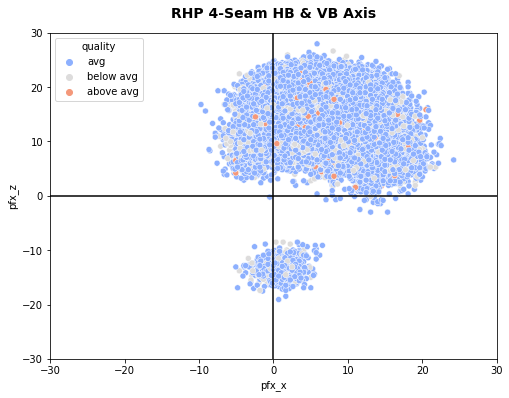

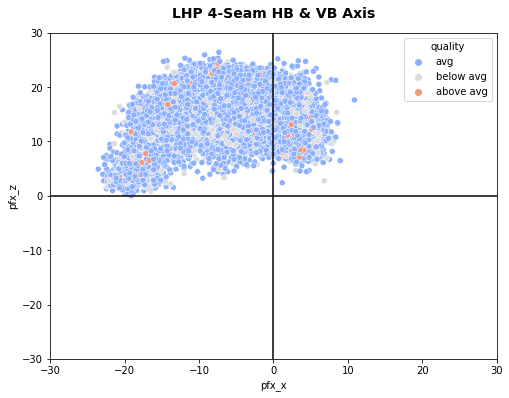

In [16]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = ff_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = ff_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

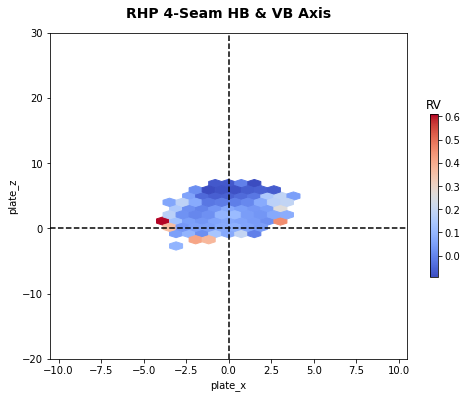

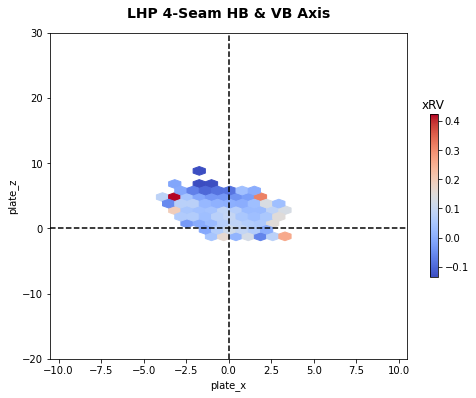

In [17]:
plt.figure(figsize = (8, 6))
plt.hexbin(ff_r_stats['plate_x'], ff_r_stats['plate_z'], C = ff_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ff_l_stats['plate_x'], ff_l_stats['plate_z'], C = ff_l_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP 4-Seam HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best 4-Seam Heatmaps

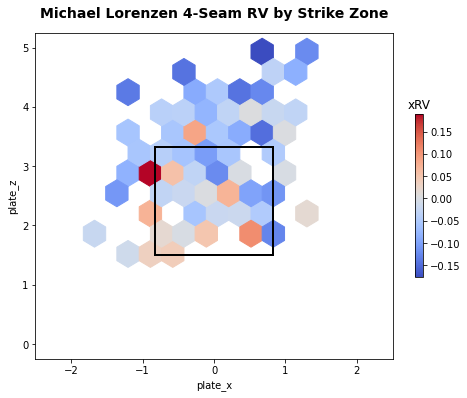

In [18]:
plt.figure(figsize = (8, 6))

plt.hexbin(lorenzen['plate_x'], lorenzen['plate_z'], C = lorenzen['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(-.25, 5.25)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Michael Lorenzen 4-Seam RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

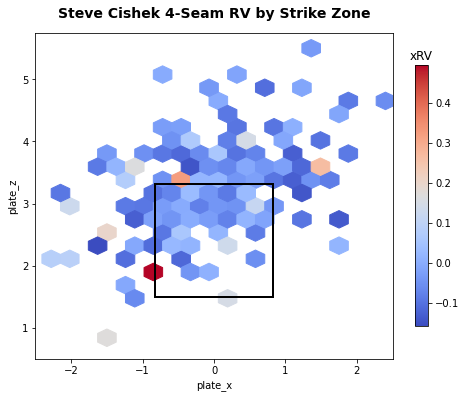

In [19]:
plt.figure(figsize = (8, 6))

plt.hexbin(cishek['plate_x'], cishek['plate_z'], C = cishek['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .8)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(.5, 5.75)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Steve Cishek 4-Seam RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

## Cutter RV/100 Leaders

In [20]:
fc_stats = xrv.loc[xrv['pitch_type'] == 'FC']

fc_stats['quality'] = ['avg' if (x >= -0.13) & (x <= 0.23) else 'above avg' if x <= -0.13 else 'below avg' for x
                       in fc_stats['xRV']]

fc_r_stats = fc_stats.loc[fc_stats['p_throws'] == 'R']
fc_l_stats = fc_stats.loc[fc_stats['p_throws'] == 'L']

fc_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.000000,47442.0,47442.000000
mean,88.526477,2369.323743,-1.380774,7.923867,0.427809,5.901672,6.260598,-0.158903,2.327181,0.039397,1.0,0.048905
std,3.403390,235.369693,3.867322,4.155338,1.993341,0.430094,0.378557,0.855116,0.888757,0.304585,0.0,0.179172
min,74.200000,360.000000,-18.000000,-14.520000,-4.400000,3.600000,4.400000,-3.940000,-3.100000,-0.203000,1.0,-0.189000
25%,86.200000,2213.000000,-4.320000,5.400000,-1.670000,5.610000,6.000000,-0.760000,1.750000,-0.016000,1.0,-0.018750
50%,88.300000,2363.000000,-1.680000,7.800000,1.180000,5.910000,6.300000,-0.180000,2.330000,-0.004000,1.0,0.010000
75%,90.500000,2525.000000,1.440000,10.440000,1.890000,6.220000,6.500000,0.440000,2.920000,0.001000,1.0,0.058000
max,102.600000,3195.000000,16.080000,23.280000,4.010000,7.100000,7.900000,3.250000,5.970000,2.128000,1.0,1.732000


In [21]:
print('fc mean:', round(fc_stats['xRV'].mean(), 2))
print('M - 1SD:', round(fc_stats['xRV'].mean() - fc_stats['xRV'].std(), 2))
print('M + 1SD:', round(fc_stats['xRV'].mean() + fc_stats['xRV'].std(), 2))
print('M - 2SD:', round(fc_stats['xRV'].mean() - (2 * fc_stats['xRV'].std()), 2))
print('M + 2SD:', round(fc_stats['xRV'].mean() + (2 * fc_stats['xRV'].std()), 2))
print('M - 3SD:', round(fc_stats['xRV'].mean() - (3 * fc_stats['xRV'].std()), 2))
print('M + 3SD:', round(fc_stats['xRV'].mean() + (3 * fc_stats['xRV'].std()), 2))

fc mean: 0.05
M - 1SD: -0.13
M + 1SD: 0.23
M - 2SD: -0.31
M + 2SD: 0.41
M - 3SD: -0.49
M + 3SD: 0.59


## Cutter xRV/100 Leaderboard

In [22]:
fc_leaders = fc.sort_values(by = ['xRV/100'])
fc_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
fc_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
971,"Alvarado, José",L,FC,170.0,-5.499,-3.23
984,"Enns, Dietrich",L,FC,133.0,-0.855,-0.64
825,"Chatwood, Tyler",R,FC,214.0,0.022,0.01
976,"Bleier, Richard",L,FC,158.0,0.086,0.05
921,"Rucker, Michael",R,FC,135.0,0.554,0.41
1010,"Newcomb, Sean",L,FC,170.0,0.962,0.57
949,"Voth, Austin",R,FC,139.0,1.389,1.00
848,"Garcia, Luis",R,FC,565.0,6.479,1.15
845,"Fulmer, Carson",R,FC,106.0,1.834,1.73
841,"Fedde, Erick",R,FC,554.0,9.747,1.76


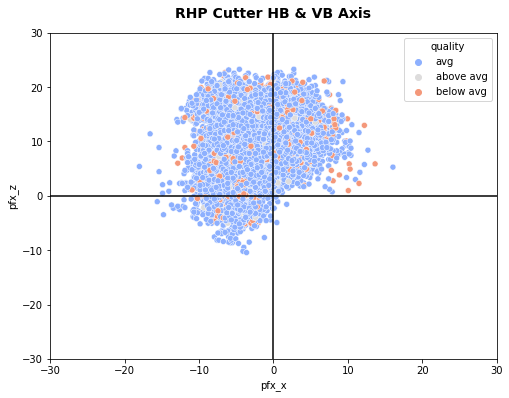

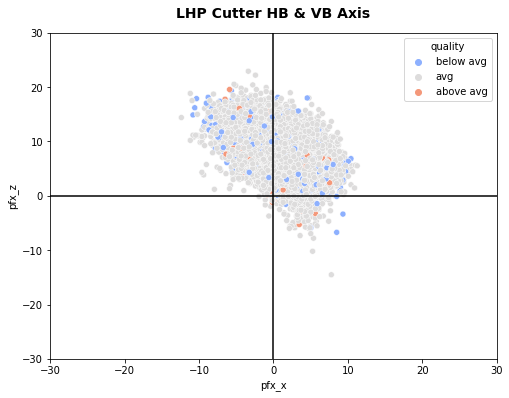

In [23]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = fc_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = fc_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

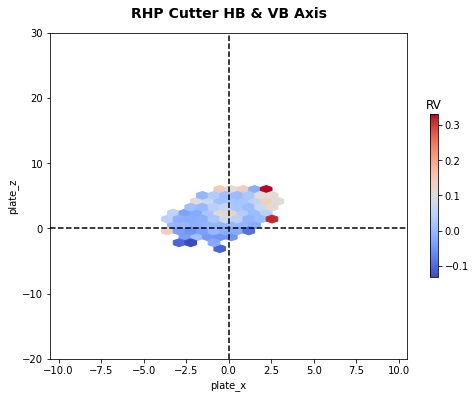

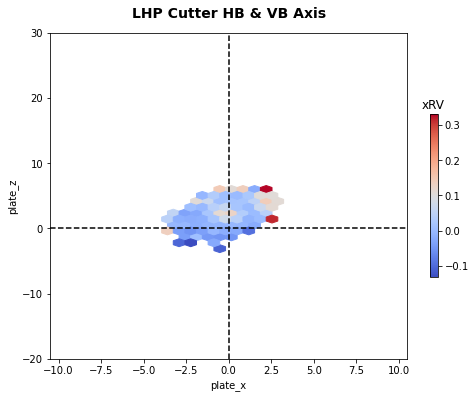

In [24]:
plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['plate_x'], fc_r_stats['plate_z'], C = fc_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fc_r_stats['plate_x'], fc_r_stats['plate_z'], C = fc_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Cutter HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Cutter Heatmaps

In [25]:
alvarado = xrv.loc[(xrv['player_name'] == 'Alvarado, José') & (xrv['pitch_type'] == 'FC')]

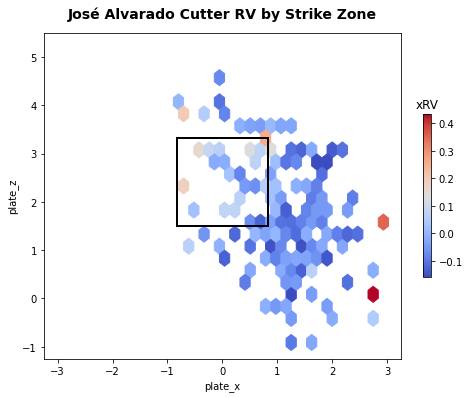

In [26]:
plt.figure(figsize = (8, 6))

plt.hexbin(alvarado['plate_x'], alvarado['plate_z'], C = alvarado['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('José Alvarado Cutter RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

## Sinker RV/100 Leaders

In [27]:
si_stats = xrv.loc[xrv['pitch_type'] == 'SI']

In [28]:
si_stats['quality'] = ['avg' if (x >= -0.11) & (x <= 0.25) else 'above avg' if x <= -0.11 else 'below avg' for x
                       in si_stats['xRV']]

si_r_stats = si_stats.loc[si_stats['p_throws'] == 'R']
si_l_stats = si_stats.loc[si_stats['p_throws'] == 'L']

si_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.000000,109145.0,109145.000000
mean,93.006648,2123.474351,5.647514,9.230005,0.655727,5.730723,6.307131,0.076329,2.335188,0.058455,1.0,0.068292
std,2.971813,185.031830,14.019857,4.767433,1.982204,0.591366,0.449247,0.831188,0.796774,0.310015,0.0,0.181078
min,66.300000,267.000000,-25.440000,-16.320000,-4.610000,0.970000,3.800000,-4.110000,-1.640000,-0.203000,1.0,-0.186000
25%,91.300000,2006.000000,-12.600000,6.480000,-1.420000,5.510000,6.000000,-0.500000,1.810000,-0.016000,1.0,-0.007000
50%,93.100000,2121.000000,13.320000,9.720000,1.410000,5.790000,6.300000,0.080000,2.320000,-0.004000,1.0,0.024000
75%,94.900000,2240.000000,15.960000,12.480000,2.060000,6.090000,6.600000,0.650000,2.850000,0.001000,1.0,0.076000
max,103.400000,3550.000000,29.040000,24.240000,4.630000,7.070000,8.600000,4.390000,9.210000,2.128000,1.0,1.669000


In [29]:
print('si mean:', round(si_stats['xRV'].mean(), 2))
print('M - 1SD:', round(si_stats['xRV'].mean() - si_stats['xRV'].std(), 2))
print('M + 1SD:', round(si_stats['xRV'].mean() + si_stats['xRV'].std(), 2))
print('M - 2SD:', round(si_stats['xRV'].mean() - (2 * si_stats['xRV'].std()), 2))
print('M + 2SD:', round(si_stats['xRV'].mean() + (2 * si_stats['xRV'].std()), 2))
print('M - 3SD:', round(si_stats['xRV'].mean() - (3 * si_stats['xRV'].std()), 2))
print('M + 3SD:', round(si_stats['xRV'].mean() + (3 * si_stats['xRV'].std()), 2))

si mean: 0.07
M - 1SD: -0.11
M + 1SD: 0.25
M - 2SD: -0.29
M + 2SD: 0.43
M - 3SD: -0.47
M + 3SD: 0.61


## Sinker xRV/100 Leaderboard

In [30]:
si_leaders = si.sort_values(by = ['xRV/100'])
si_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
si_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
1259,"Nola, Aaron",R,SI,419.0,5.195,1.24
1497,"Rodriguez, Eduardo",L,SI,305.0,3.950,1.30
1070,"Burnes, Corbin",R,SI,236.0,3.121,1.32
1306,"Sadler, Casey",R,SI,156.0,2.388,1.53
1521,"Suárez, Ranger",L,SI,734.0,13.191,1.80
1108,"DeSclafani, Anthony",R,SI,473.0,11.243,2.38
1104,"Darvish, Yu",R,SI,229.0,6.085,2.66
1152,"Graveman, Kendall",R,SI,548.0,14.920,2.72
1468,"Matz, Steven",L,SI,1327.0,38.884,2.93
1469,"Mayza, Tim",L,SI,595.0,18.418,3.10


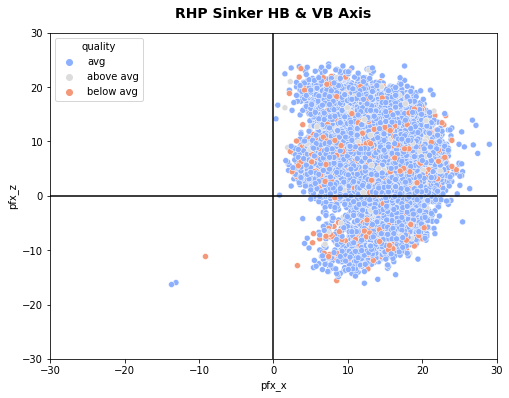

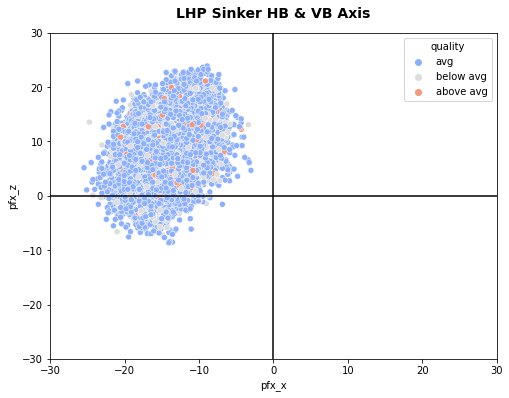

In [31]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = si_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = si_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## HB & VB

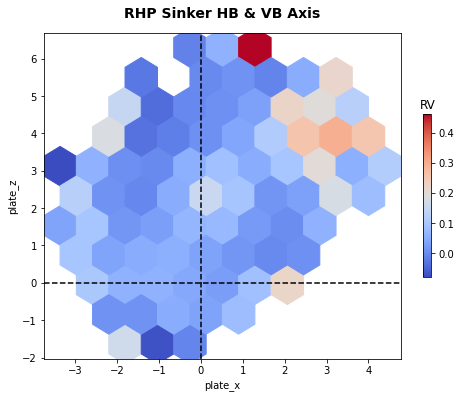

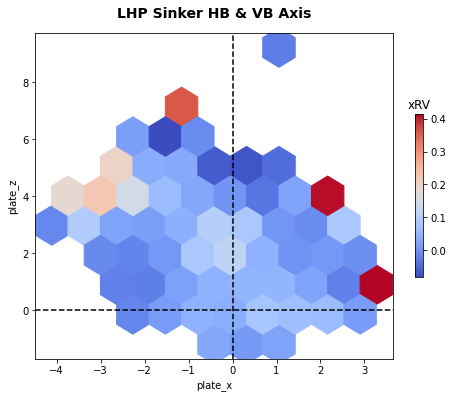

In [32]:
plt.figure(figsize = (8, 6))
plt.hexbin(si_r_stats['plate_x'], si_r_stats['plate_z'], C = si_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
#plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(si_l_stats['plate_x'], si_l_stats['plate_z'], C = si_l_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
#plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Sinker HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Sinker Heatmaps

In [33]:
nola = xrv.loc[(xrv['player_name'] == 'Nola, Aaron') & (xrv['pitch_type'] == 'SI')]
rodriguez = xrv.loc[(xrv['player_name'] == 'Rodriguez, Eduardo') & (xrv['pitch_type'] == 'SI')]

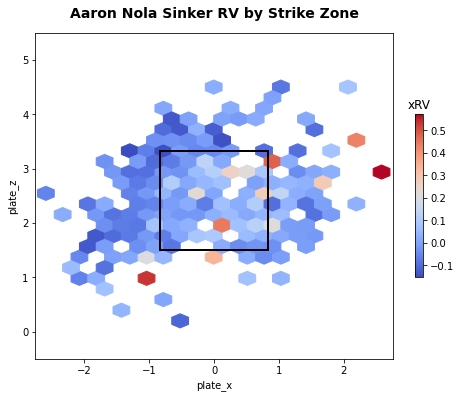

In [34]:
plt.figure(figsize = (8, 6))

plt.hexbin(nola['plate_x'], nola['plate_z'], C = nola['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Aaron Nola Sinker RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

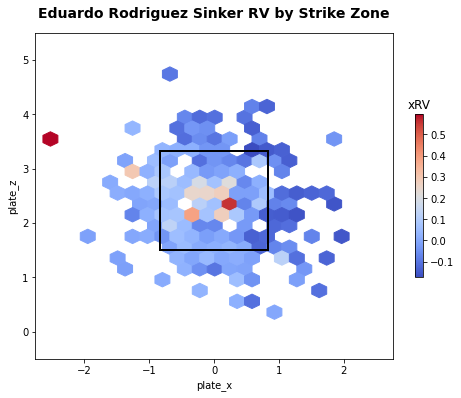

In [35]:
plt.figure(figsize = (8, 6))

plt.hexbin(rodriguez['plate_x'], rodriguez['plate_z'], C = rodriguez['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Eduardo Rodriguez Sinker RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

## Slider RV/100 Leaders

In [36]:
sl_stats = xrv.loc[xrv['pitch_type'] == 'SL']
sl_stats['quality'] = ['avg' if (x >= -0.15) & (x <= 0.19) else 'above avg' if x <= -0.15 else 'below avg' for x
                       in sl_stats['xRV']]

sl_r_stats = sl_stats.loc[sl_stats['p_throws'] == 'R']
sl_l_stats = sl_stats.loc[sl_stats['p_throws'] == 'L']

sl_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.000000,135533.0,135533.000000
mean,84.652361,2417.424502,-3.221783,1.704358,0.931846,5.795487,6.258316,-0.232509,1.885368,0.008699,1.0,0.016868
std,3.512708,264.636892,7.422867,4.433631,1.874394,0.594536,0.457759,0.919451,0.934011,0.286980,0.0,0.170605
min,35.900000,291.000000,-34.080000,-19.680000,-4.370000,0.940000,3.600000,-4.890000,-5.070000,-0.203000,1.0,-0.188000
25%,82.600000,2239.000000,-7.320000,-1.320000,-0.580000,5.560000,5.900000,-0.860000,1.280000,-0.149000,1.0,-0.058000
50%,85.000000,2410.000000,-3.480000,1.680000,1.600000,5.860000,6.300000,-0.260000,1.890000,-0.007000,1.0,-0.011000
75%,87.000000,2585.000000,1.200000,4.680000,2.230000,6.160000,6.600000,0.380000,2.500000,-0.004000,1.0,0.030000
max,95.500000,3600.000000,26.640000,28.800000,4.670000,7.440000,8.400000,4.740000,9.390000,2.128000,1.0,1.626000


In [37]:
print('sl mean:', round(sl_stats['xRV'].mean(), 2))
print('M - 1SD:', round(sl_stats['xRV'].mean() - sl_stats['xRV'].std(), 2))
print('M + 1SD:', round(sl_stats['xRV'].mean() + sl_stats['xRV'].std(), 2))
print('M - 2SD:', round(sl_stats['xRV'].mean() - (2 * sl_stats['xRV'].std()), 2))
print('M + 2SD:', round(sl_stats['xRV'].mean() + (2 * sl_stats['xRV'].std()), 2))
print('M - 3SD:', round(sl_stats['xRV'].mean() - (3 * sl_stats['xRV'].std()), 2))
print('M + 3SD:', round(sl_stats['xRV'].mean() + (3 * sl_stats['xRV'].std()), 2))

sl mean: 0.02
M - 1SD: -0.15
M + 1SD: 0.19
M - 2SD: -0.32
M + 2SD: 0.36
M - 3SD: -0.49
M + 3SD: 0.53


## Slider xRV/100 Leaders

In [38]:
sl_leaders = sl.sort_values(by = ['xRV/100'])
sl_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
sl_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
2072,"Bummer, Aaron",L,SL,281.0,-15.021,-5.35
1739,"Hendriks, Liam",R,SL,235.0,-10.134,-4.31
2178,"Rodón, Carlos",L,SL,603.0,-23.895,-3.96
1798,"Leone, Dominic",R,SL,230.0,-8.680,-3.77
1653,"Dunn, Justin",R,SL,129.0,-4.591,-3.56
2204,"Steele, Justin",L,SL,161.0,-5.090,-3.16
2070,"Brothers, Rex",L,SL,344.0,-10.100,-2.94
2050,"deGrom, Jacob",R,SL,409.0,-9.942,-2.43
1894,"Phillips, Evan",R,SL,108.0,-2.450,-2.27
1913,"Rasmussen, Drew",R,SL,361.0,-8.169,-2.26


## Slider HB & VB

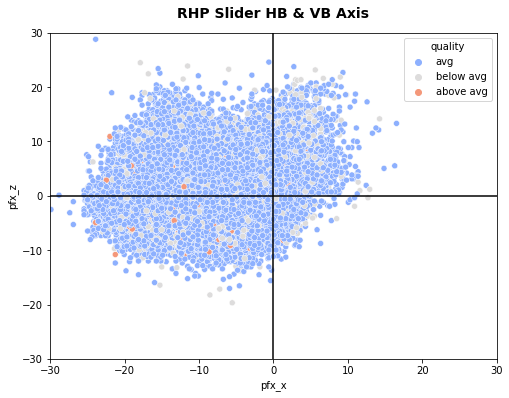

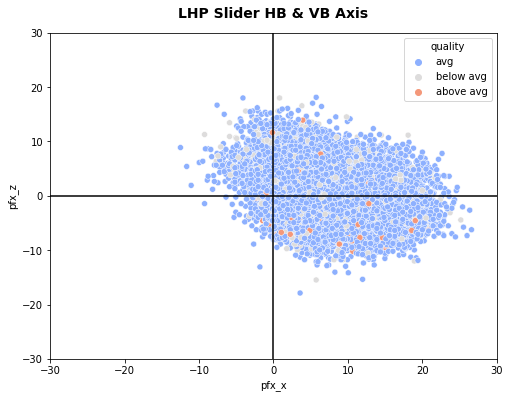

In [39]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = sl_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = sl_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

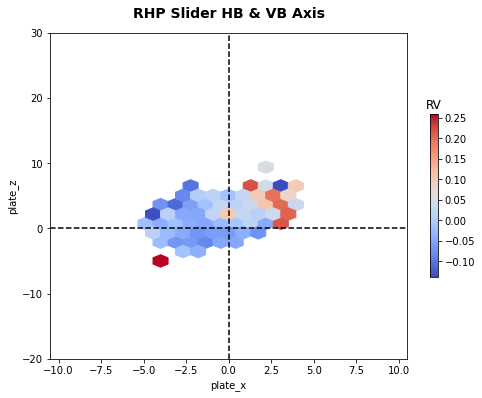

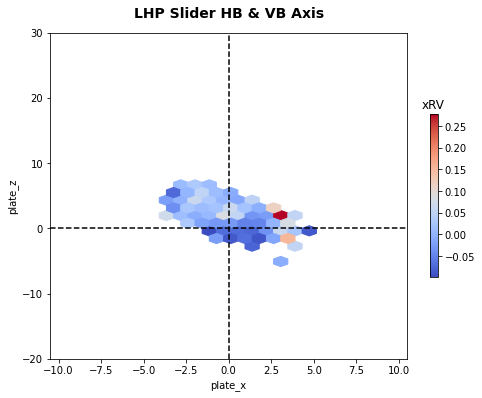

In [40]:
plt.figure(figsize = (8, 6))
plt.hexbin(sl_r_stats['plate_x'], sl_r_stats['plate_z'], C = sl_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(sl_l_stats['plate_x'], sl_l_stats['plate_z'], C = sl_l_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Slider HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Slider Heatmaps

In [41]:
hendriks = xrv.loc[(xrv['player_name'] == 'Hendriks, Liam') & (xrv['pitch_type'] == 'SL')]
steele = xrv.loc[(xrv['player_name'] == 'Steele, Justin') & (xrv['pitch_type'] == 'SL')]
deGrom = xrv.loc[(xrv['player_name'] == 'deGrom, Jacob') & (xrv['pitch_type'] == 'SL')]

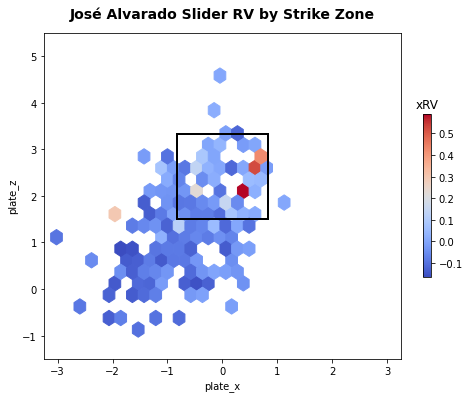

In [42]:
plt.figure(figsize = (8, 6))

plt.hexbin(hendriks['plate_x'], hendriks['plate_z'], C = hendriks['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('José Alvarado Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

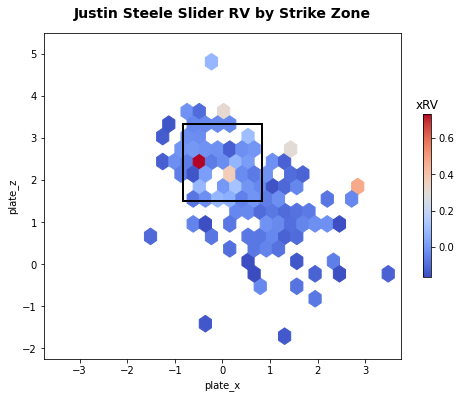

In [43]:
plt.figure(figsize = (8, 6))

plt.hexbin(steele['plate_x'], steele['plate_z'], C = steele['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.75, 3.75), plt.ylim(-2.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Justin Steele Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

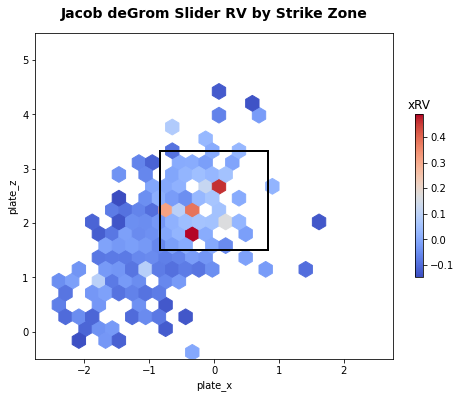

In [44]:
plt.figure(figsize = (8, 6))

plt.hexbin(deGrom['plate_x'], deGrom['plate_z'], C = deGrom['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Jacob deGrom Slider RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

## Curveball RV/100 Leaders

In [45]:
cu_stats = xrv.loc[xrv['pitch_type'] == 'CU']
cu_stats['quality'] = ['avg' if (x >= -0.15) & (x <= 0.16) else 'above avg' if x <= -0.15 else 'below avg' for x
                       in cu_stats['xRV']]

cu_r_stats = cu_stats.loc[cu_stats['p_throws'] == 'R']
cu_l_stats = cu_stats.loc[cu_stats['p_throws'] == 'L']

cu_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.000000,58770.0,58770.000000
mean,78.744136,2506.825898,-3.862663,-8.741015,0.516107,5.975537,6.208064,-0.068508,1.833346,0.000856,1.0,0.007677
std,3.886024,324.934051,9.996679,5.847554,1.820407,0.428738,0.427571,0.881018,1.072030,0.264672,0.0,0.157060
min,39.600000,95.000000,-29.400000,-25.560000,-4.430000,1.870000,2.800000,-8.830000,-4.320000,-0.203000,1.0,-0.193000
25%,76.500000,2287.000000,-11.520000,-13.200000,-1.350000,5.720000,5.900000,-0.640000,1.150000,-0.149000,1.0,-0.060000
50%,79.200000,2499.000000,-6.360000,-9.480000,1.220000,6.020000,6.200000,-0.070000,1.840000,-0.007000,1.0,-0.012000
75%,81.400000,2731.000000,3.720000,-4.680000,1.880000,6.250000,6.500000,0.500000,2.530000,-0.004000,1.0,0.023000
max,91.500000,3722.000000,27.840000,21.600000,5.340000,7.930000,7.800000,5.000000,8.800000,2.128000,1.0,1.549000


In [46]:
print('cu mean:', round(cu_stats['xRV'].mean(), 2))
print('M - 1SD:', round(cu_stats['xRV'].mean() - cu_stats['xRV'].std(), 2))
print('M + 1SD:', round(cu_stats['xRV'].mean() + cu_stats['xRV'].std(), 2))
print('M - 2SD:', round(cu_stats['xRV'].mean() - (2 * cu_stats['xRV'].std()), 2))
print('M + 2SD:', round(cu_stats['xRV'].mean() + (2 * cu_stats['xRV'].std()), 2))
print('M - 3SD:', round(cu_stats['xRV'].mean() - (3 * cu_stats['xRV'].std()), 2))
print('M + 3SD:', round(cu_stats['xRV'].mean() + (3 * cu_stats['xRV'].std()), 2))

cu mean: 0.01
M - 1SD: -0.15
M + 1SD: 0.16
M - 2SD: -0.31
M + 2SD: 0.32
M - 3SD: -0.46
M + 3SD: 0.48


## Curveball xRV/100 Leaders

In [47]:
cu_leaders = cu.sort_values(by = ['xRV/100'])
cu_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
cu_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
2329,"Glasnow, Tyler",R,CU,183.0,-16.120,-8.81
2357,"Hendriks, Liam",R,CU,107.0,-8.800,-8.22
2630,"Luetge, Lucas",L,CU,189.0,-13.925,-7.37
2525,"Trivino, Lou",R,CU,133.0,-4.793,-3.60
2245,"Bassitt, Chris",R,CU,155.0,-4.728,-3.05
2264,"Burnes, Corbin",R,CU,473.0,-13.827,-2.92
2416,"McKenzie, Triston",R,CU,356.0,-9.624,-2.70
2517,"Thompson, Keegan",R,CU,222.0,-5.848,-2.63
2551,"Woodruff, Brandon",R,CU,468.0,-10.901,-2.33
2505,"Staumont, Josh",R,CU,380.0,-8.082,-2.13


## Curveball HB & VB

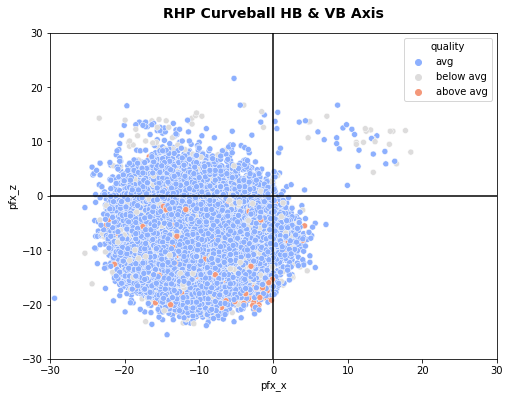

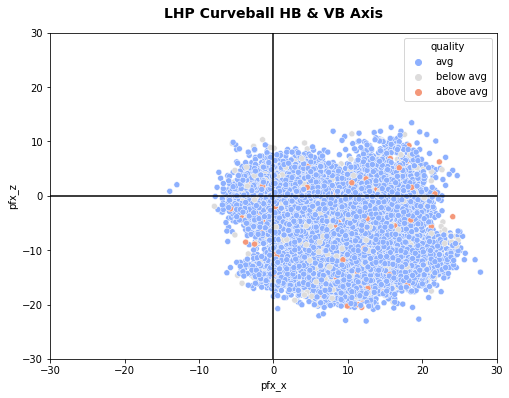

In [48]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = cu_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = cu_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

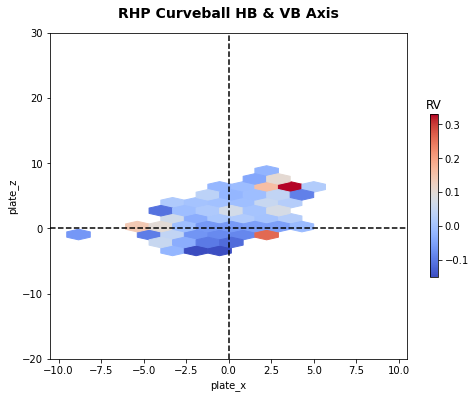

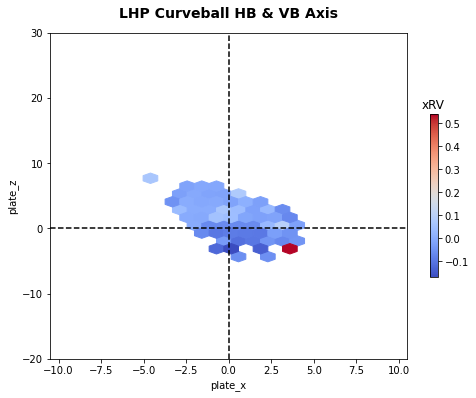

In [49]:
plt.figure(figsize = (8, 6))
plt.hexbin(cu_r_stats['plate_x'], cu_r_stats['plate_z'], C = cu_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(cu_l_stats['plate_x'], cu_l_stats['plate_z'], C = cu_l_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Curveball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Bets Curveball Heatmaps

In [50]:
glasnow = xrv.loc[(xrv['player_name'] == 'Glasnow, Tyler') & (xrv['pitch_type'] == 'CU')]
burnes = xrv.loc[(xrv['player_name'] == 'Burnes, Corbin') & (xrv['pitch_type'] == 'CU')]

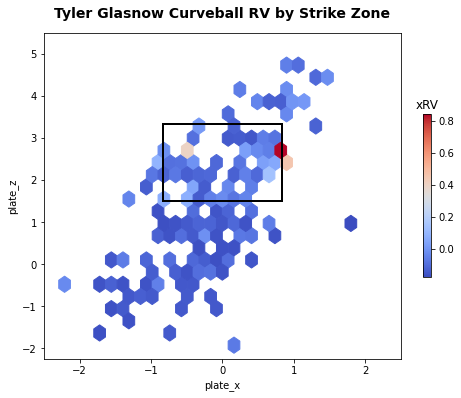

In [51]:
plt.figure(figsize = (8, 6))

plt.hexbin(glasnow['plate_x'], glasnow['plate_z'], C = glasnow['xRV'], cmap = 'coolwarm', gridsize = 25)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.5, 2.5), plt.ylim(-2.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Tyler Glasnow Curveball RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

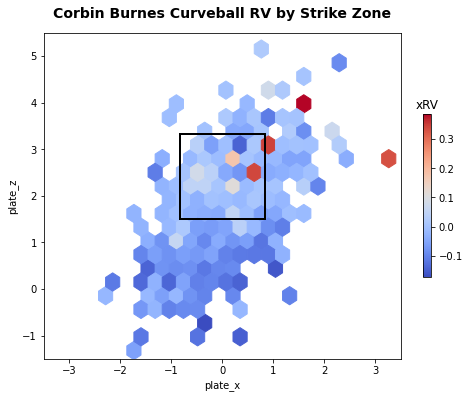

In [52]:
plt.figure(figsize = (8, 6))

plt.hexbin(burnes['plate_x'], burnes['plate_z'], C = burnes['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.5, 3.5), plt.ylim(-1.5, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Corbin Burnes Curveball RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

## Changeup RV/100 Leaders

In [53]:
ch_stats = xrv.loc[xrv['pitch_type'] == 'CH']
ch_stats['quality'] = ['avg' if (x >= -0.15) & (x <= 0.21) else 'above avg' if x <= -0.15 else 'below avg' for x
                       in ch_stats['xRV']]

ch_r_stats = ch_stats.loc[ch_stats['p_throws'] == 'R']
ch_l_stats = ch_stats.loc[ch_stats['p_throws'] == 'L']

ch_stats.describe()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.000000,80330.0,80330.000000
mean,84.806887,1749.619781,3.593931,6.828759,0.469775,5.796717,6.306985,0.040431,1.850276,0.023993,1.0,0.033069
std,3.524400,299.480706,13.825781,4.907631,2.039148,0.440081,0.452686,0.874606,0.901523,0.300844,0.0,0.179274
min,43.800000,43.000000,-27.000000,-15.720000,-4.460000,2.160000,3.700000,-9.110000,-3.580000,-0.203000,1.0,-0.188000
25%,82.600000,1546.000000,-12.720000,3.600000,-1.710000,5.530000,6.000000,-0.560000,1.260000,-0.149000,1.0,-0.040000
50%,85.100000,1714.000000,11.160000,6.960000,1.400000,5.820000,6.300000,0.050000,1.840000,-0.007000,1.0,-0.001000
75%,87.200000,1935.000000,15.120000,10.200000,2.090000,6.090000,6.600000,0.630000,2.420000,0.000000,1.0,0.046000
max,95.500000,3595.000000,29.640000,23.400000,4.580000,7.280000,9.000000,4.680000,8.390000,2.128000,1.0,1.615000


In [54]:
print('ch mean:', round(ch_stats['xRV'].mean(), 2))
print('M - 1SD:', round(ch_stats['xRV'].mean() - ch_stats['xRV'].std(), 2))
print('M + 1SD:', round(ch_stats['xRV'].mean() + ch_stats['xRV'].std(), 2))
print('M - 2SD:', round(ch_stats['xRV'].mean() - (2 * ch_stats['xRV'].std()), 2))
print('M + 2SD:', round(ch_stats['xRV'].mean() + (2 * ch_stats['xRV'].std()), 2))
print('M - 3SD:', round(ch_stats['xRV'].mean() - (3 * ch_stats['xRV'].std()), 2))
print('M + 3SD:', round(ch_stats['xRV'].mean() + (3 * ch_stats['xRV'].std()), 2))


ch mean: 0.03
M - 1SD: -0.15
M + 1SD: 0.21
M - 2SD: -0.33
M + 2SD: 0.39
M - 3SD: -0.5
M + 3SD: 0.57


## Changeup xRV/100 Leaders

In [55]:
ch_leaders = ch.sort_values(by = ['xRV/100'])
ch_leaders.drop(columns = ['RV', 'RV/100'], inplace = True)
ch_leaders.head(10)

,player_name,p_throws,pitch_type,n_pitches,xRV,xRV/100
3052,"Romo, Sergio",R,CH,112.0,-3.009,-2.69
2934,"Knehr, Reiss",R,CH,116.0,-2.132,-1.84
3243,"Kikuchi, Yusei",L,CH,269.0,-2.714,-1.01
3066,"Scherzer, Max",R,CH,421.0,-3.097,-0.74
3099,"Sulser, Cole",R,CH,355.0,-2.018,-0.57
2823,"Fedde, Erick",R,CH,245.0,-1.352,-0.55
2926,"Kelly, Joe",R,CH,115.0,-0.586,-0.51
2875,"Greinke, Zack",R,CH,569.0,-2.035,-0.36
2833,"Flexen, Chris",R,CH,431.0,-1.396,-0.32
2705,"Alzolay, Adbert",R,CH,138.0,-0.384,-0.28


## Changeup HB & VB

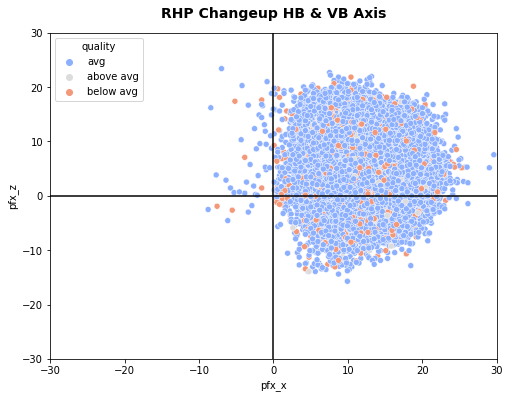

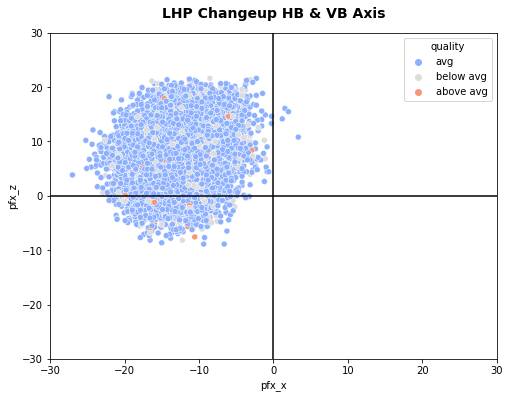

In [56]:
plt.figure(figsize = (8, 6))
sns.scatterplot(data = ch_r_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('RHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
sns.scatterplot(data = ch_l_stats, x = 'pfx_x', y = 'pfx_z', hue = 'quality', 
                palette = 'coolwarm', legend = 'full')
plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black'), plt.axvline(0, color = 'black')
plt.title('LHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

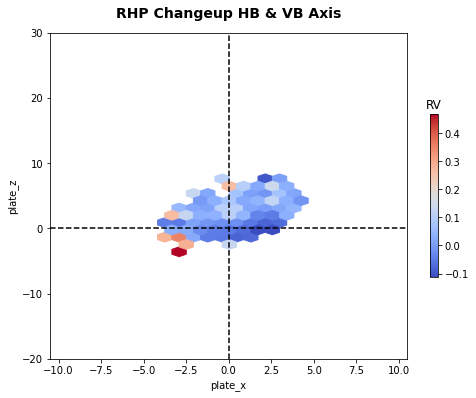

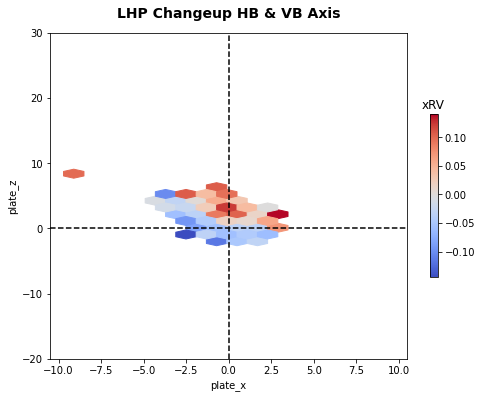

In [57]:
plt.figure(figsize = (8, 6))
plt.hexbin(ch_r_stats['plate_x'], ch_r_stats['plate_z'], C = ch_r_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(ch_l_stats['plate_x'], ch_l_stats['plate_z'], C = ch_l_stats['xRV'], cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Changeup HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Best Changeup Heatmaps

In [58]:
scherzer = xrv.loc[(xrv['player_name'] == 'Scherzer, Max') & (xrv['pitch_type'] == 'CH')]
greinke = xrv.loc[(xrv['player_name'] == 'Greinke, Zack') & (xrv['pitch_type'] == 'CH')]

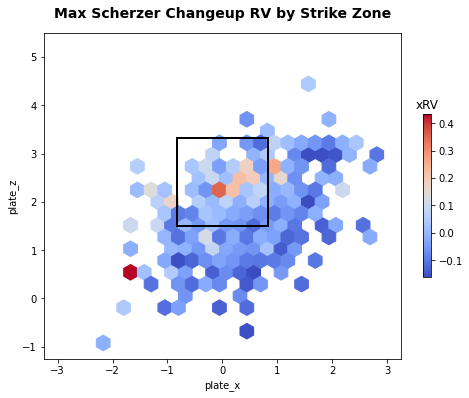

In [59]:
plt.figure(figsize = (8, 6))

plt.hexbin(scherzer['plate_x'], scherzer['plate_z'], C = scherzer['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z') 
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-3.25, 3.25), plt.ylim(-1.25, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Max Scherzer Changeup RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

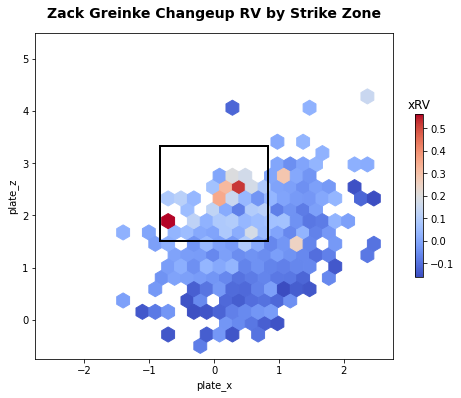

In [60]:
plt.figure(figsize = (8, 6))

plt.hexbin(greinke['plate_x'], greinke['plate_z'], C = greinke['xRV'], cmap = 'coolwarm', gridsize = 20)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
plt.xlim(-2.75, 2.75), plt.ylim(-.75, 5.5)
plt.gca().add_patch(Rectangle((-.83, 1.5), 1.66, 1.82, fill = False, color = 'black', linewidth = 2))
plt.title('Zack Greinke Changeup RV by Strike Zone', fontsize = 14, fontweight = 'bold', pad = 15);

# Grouped Pitches

## Fastball
4-Seam, Cutter, Sinker

In [61]:
g_ff = xrv.loc[xrv['pitch_type'] == 'FF']
g_fc = xrv.loc[xrv['pitch_type'] == 'FC']
fastball_stats = g_ff.append(g_fc)
g_si = xrv.loc[xrv['pitch_type'] == 'SI']
print(fastball_stats.shape)
fastball_stats = fastball_stats.append(g_si)

fastball_stats['quality'] = ['avg' if (x >= -0.13) & (x <= 0.23) else 'above avg' if x <= -0.13 
                             else 'below avg' for x in fastball_stats['xRV']]

fastball_r_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'R']
fastball_l_stats = fastball_stats.loc[fastball_stats['p_throws'] == 'L']

fastball_stats.describe()

(297105, 15)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
count,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.000000,406250.0,406250.000000
mean,92.910522,2244.299131,3.102286,13.300776,0.657699,5.864830,6.338833,0.000806,2.585154,0.042981,1.0,0.053972
std,3.211609,206.380993,9.801343,5.236159,1.889133,0.534216,0.439245,0.798952,0.873999,0.309645,0.0,0.181524
min,59.200000,117.000000,-25.440000,-19.080000,-4.610000,0.970000,3.600000,-4.110000,-3.100000,-0.203000,1.0,-0.189000
25%,91.200000,2109.000000,-4.560000,10.080000,-1.310000,5.620000,6.000000,-0.550000,2.000000,-0.016000,1.0,-0.017000
50%,93.300000,2243.000000,4.920000,14.520000,1.370000,5.900000,6.300000,-0.000000,2.570000,-0.004000,1.0,0.016000
75%,95.100000,2376.000000,10.800000,17.160000,2.020000,6.190000,6.600000,0.550000,3.160000,0.001000,1.0,0.064000
max,103.400000,3594.000000,29.040000,27.960000,4.640000,7.190000,8.600000,4.390000,9.210000,2.128000,1.0,1.732000


In [62]:
print('FF mean:', round(ff_stats['xRV'].mean(), 2))
print('M - 1SD:', round(ff_stats['xRV'].mean() - ff_stats['xRV'].std(), 2))
print('M + 1SD:', round(ff_stats['xRV'].mean() + ff_stats['xRV'].std(), 2))
print('M - 2SD:', round(ff_stats['xRV'].mean() - (2 * ff_stats['xRV'].std()), 2))
print('M + 2SD:', round(ff_stats['xRV'].mean() + (2 * ff_stats['xRV'].std()), 2))
print('M - 3SD:', round(ff_stats['xRV'].mean() - (3 * ff_stats['xRV'].std()), 2))
print('M + 3SD:', round(ff_stats['xRV'].mean() + (3 * ff_stats['xRV'].std()), 2))

FF mean: 0.05
M - 1SD: -0.13
M + 1SD: 0.23
M - 2SD: -0.31
M + 2SD: 0.41
M - 3SD: -0.5
M + 3SD: 0.59


## Fastball HB & VB

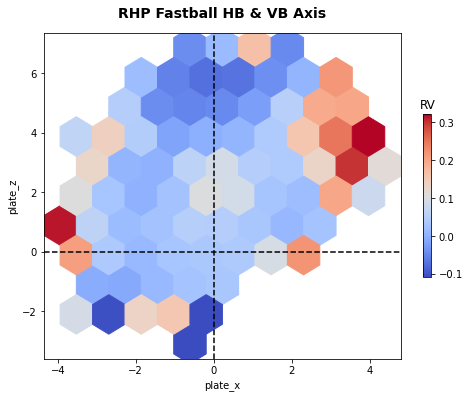

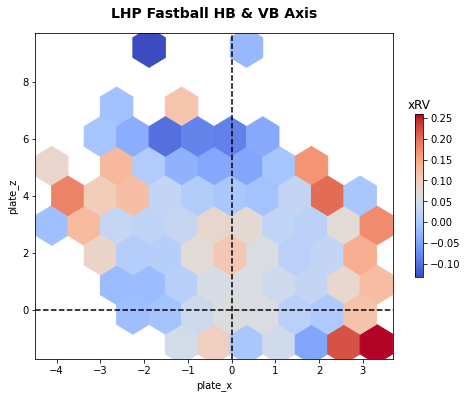

In [63]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_r_stats['plate_x'], fastball_r_stats['plate_z'], C = fastball_r_stats['xRV'], 
           cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('RV')
#plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (8, 6))
plt.hexbin(fastball_l_stats['plate_x'], fastball_l_stats['plate_z'], C = fastball_l_stats['xRV'], 
           cmap = 'coolwarm', gridsize = 10)
plt.xlabel('plate_x'), plt.ylabel('plate_z')
cb = plt.colorbar(shrink = .5)
cb.ax.set_title('xRV')
#plt.xlim(-10.5, 10.5), plt.ylim(-20, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Breaking Ball
Slider, Curveball, Knuckle Curve

In [64]:
g_sl = xrv.loc[xrv['pitch_type'] == 'SL']
g_cu = xrv.loc[xrv['pitch_type'] == 'CU']
bb_stats = g_sl.append(g_cu)
g_kc = xrv.loc[xrv['pitch_type'] == 'KC']
bb_stats = bb_stats.append(g_kc)
print(bb_stats.shape)
bb_stats.head()

(194303, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
406250,"Gsellman, Robert",R,SL,90.8,2052.0,0.36,5.04,1.48,5.95,6.4,-0.98,1.12,-0.149,1,-0.127
406251,"Gsellman, Robert",R,SL,90.0,2110.0,-0.24,7.44,1.45,5.94,6.3,-0.21,1.95,-0.149,1,0.078
406252,"Gsellman, Robert",R,SL,89.3,2180.0,-1.68,2.88,1.63,5.96,6.4,-1.63,1.92,-0.004,1,-0.030
406253,"Gsellman, Robert",R,SL,90.5,2133.0,-0.12,7.44,1.51,5.93,6.3,-0.01,2.23,-0.170,1,-0.086
406254,"Martin, Chris",R,SL,84.9,2593.0,-6.60,-10.80,3.02,6.35,6.3,1.18,1.25,-0.170,1,-0.039


## Off-Speed
Changeup, Splitter

In [65]:
g_ch = xrv.loc[xrv['pitch_type'] == 'CH']
g_fs = xrv.loc[xrv['pitch_type'] == 'FS']
os_stats = g_ch.append(g_fs)
print(os_stats.shape)
os_stats.head()

(80330, 15)


,player_name,p_throws,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,rv,n_pitches,xRV
600553,"Martin, Chris",R,CH,87.9,1160.0,7.68,1.80,2.98,6.23,6.7,0.36,1.26,-0.170,1,-0.137
600554,"Martin, Chris",R,CH,89.2,1682.0,12.24,6.60,2.98,6.22,6.6,0.25,0.70,-0.016,1,-0.024
600555,"Martin, Chris",R,CH,86.9,1397.0,11.04,2.88,2.87,6.29,6.6,0.83,2.99,0.653,1,0.017
600556,"Martin, Chris",R,CH,88.6,1642.0,13.44,4.92,2.96,6.18,6.7,-0.43,1.46,-0.170,1,0.017
600557,"Williams, Trevor",R,CH,82.9,1725.0,10.80,2.40,2.25,5.04,6.8,1.13,1.53,-0.149,1,-0.057
